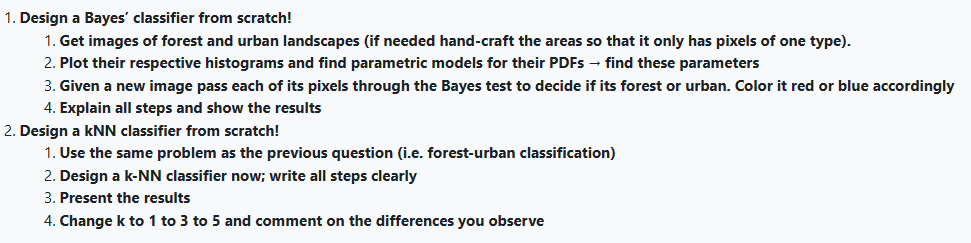

In [10]:
import glob
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from pyproj import Transformer
import scipy as sp
from scipy import optimize
from scipy import fftpack
import skopt as opt
from skimage.color import rgb2gray
from skimage.restoration import denoise_tv_chambolle
from scipy.fftpack import dct, idct
import os
from rasterio.windows import from_bounds, Window
import imageio.v2 as imageio
import math
from scipy.stats import norm, lognorm
from scipy.optimize import minimize

Forest and urban areas same as previously used (Strzelecki Park Krajobrazowy of Lubelskie Voivodeship and central Kraków area)

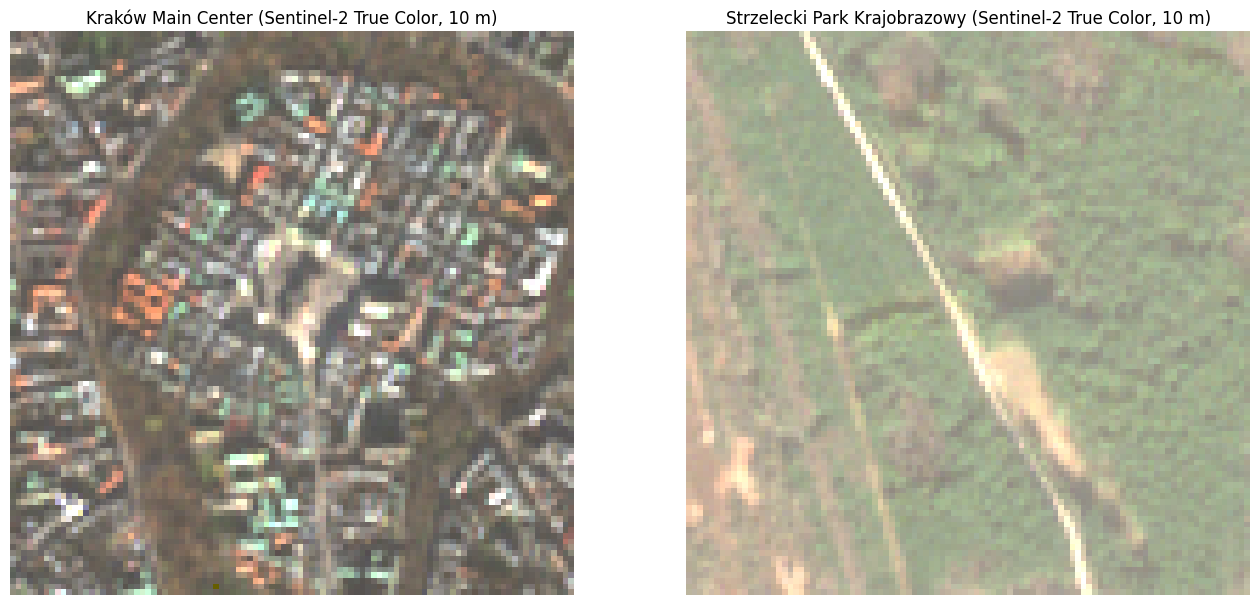

In [26]:
# Paths to the 10m bands for both urban and rural areas
folder_k = "D:\\studia\\Y5S1\\ML_for_Space_Tech\\data\\K\\S2\\S2C_MSIL2A_20251119T094321_N0511_R036_T34UDA_20251119T113511.SAFE\\GRANULE\\L2A_T34UDA_A006298_20251119T094316\\IMG_DATA\\R10m"
folder_l = "D:\\studia\\Y5S1\\ML_for_Space_Tech\\data\\L\\S2\\S2C_MSIL2A_20250130T093301_N0511_R136_T34UGB_20250130T131557.SAFE\\GRANULE\\L2A_T34UGB_A002108_20250130T093257\\IMG_DATA\\R10m"
# Paths to the r g and b bands 
band_paths_k = {b: glob.glob(f"{folder_k}/*_{b}_10m.jp2")[0] for b in ["B04", "B03", "B02"]}
band_paths_l = {b: glob.glob(f"{folder_l}/*_{b}_10m.jp2")[0] for b in ["B04", "B03", "B02"]}

lon_k, lat_k = 19.9372205, 50.0614312   # Rynek Główny coordinates
lon_l, lat_l = 23.977058, 50.968711   # Strzelecki Park Krajobrazowy coordinates

# Transforming the image coordinates from lat/lon to UTM, taking 3km x 3km area around the point
transformer = Transformer.from_crs("EPSG:4326", "EPSG:32634", always_xy=True)
x_k, y_k = transformer.transform(lon_k, lat_k)
x_l, y_l = transformer.transform(lon_l, lat_l)
dx = 500   
dy = 500   
xmin_k, ymin_k, xmax_k, ymax_k = x_k - dx, y_k - dy, x_k + dx, y_k + dy
xmin_l, ymin_l, xmax_l, ymax_l = x_l - dx, y_l - dy, x_l + dx, y_l + dy

# Helper functions to load only the cropped area of interest instead of whole image
def read_crop(path, bounds):
    with rasterio.open(path) as src:
        window = from_bounds(*bounds, transform=src.transform)
        data = src.read(1, window=window)
    return data

scale = 1.0 / 10000.0
# Crop each band for both pictures, convert to surface reflectance
b4_crop_k = read_crop(band_paths_k["B04"], (xmin_k, ymin_k, xmax_k, ymax_k)).astype(np.float32) * scale  # R
b3_crop_k = read_crop(band_paths_k["B03"], (xmin_k, ymin_k, xmax_k, ymax_k)).astype(np.float32) * scale  # G
b2_crop_k = read_crop(band_paths_k["B02"], (xmin_k, ymin_k, xmax_k, ymax_k)).astype(np.float32) * scale  # B

b4_crop_l = read_crop(band_paths_l["B04"], (xmin_l, ymin_l, xmax_l, ymax_l)).astype(np.float32) * scale  # R
b3_crop_l = read_crop(band_paths_l["B03"], (xmin_l, ymin_l, xmax_l, ymax_l)).astype(np.float32) * scale  # G
b2_crop_l = read_crop(band_paths_l["B02"], (xmin_l, ymin_l, xmax_l, ymax_l)).astype(np.float32) * scale  # B


# Stack, normalize, remove outliers
cropped_rgb_k = np.dstack((b4_crop_k, b3_crop_k, b2_crop_k)).astype(np.float32)
cropped_rgb_k /= np.percentile(cropped_rgb_k, 99)
cropped_rgb_k = np.clip(cropped_rgb_k, 0, 1)

cropped_rgb_l = np.dstack((b4_crop_l, b3_crop_l, b2_crop_l)).astype(np.float32)
cropped_rgb_l /= np.percentile(cropped_rgb_l, 99)
cropped_rgb_l = np.clip(cropped_rgb_l, 0, 1)

# Plot both images side by side
fig, axs = plt.subplots(1, 2, figsize=(16, 8))
axs[1].imshow(cropped_rgb_l)
axs[1].set_title("Strzelecki Park Krajobrazowy (Sentinel-2 True Color, 10 m)")
axs[1].axis("off")
axs[0].imshow(cropped_rgb_k)
axs[0].set_title("Kraków Main Center (Sentinel-2 True Color, 10 m)")
axs[0].axis("off")
plt.show()

Histograms (based heavily on the code from slides)

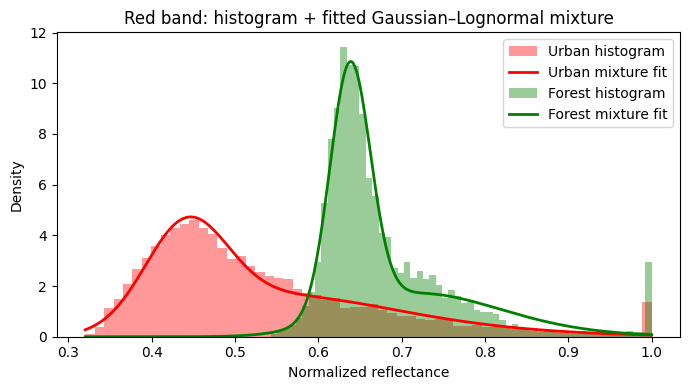


Red band parameters
Urban:  alpha=0.461, mu=0.441, sigma=0.049, m=-0.528, s=0.232
Forest: alpha=0.593, mu=0.638, sigma=0.024, m=-0.308, s=0.131


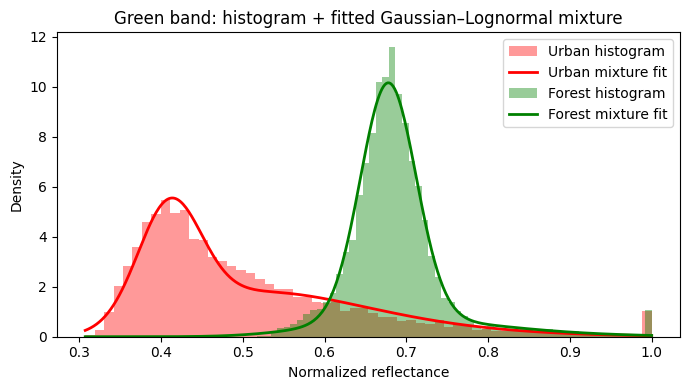


Green band parameters
Urban:  alpha=0.437, mu=0.410, sigma=0.039, m=-0.586, s=0.233
Forest: alpha=0.805, mu=0.678, sigma=0.034, m=-0.337, s=0.158


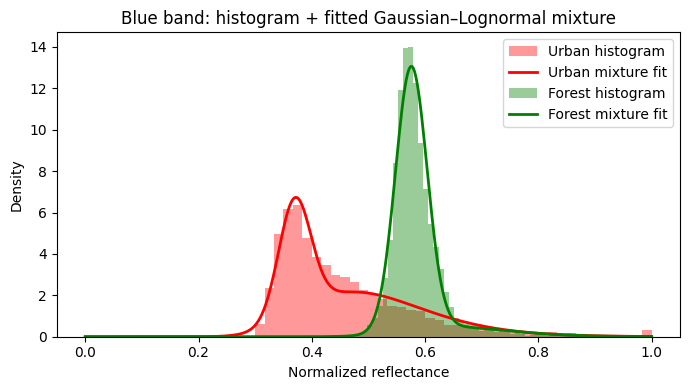


Blue band parameters
Urban:  alpha=0.393, mu=0.370, sigma=0.028, m=-0.690, s=0.230
Forest: alpha=0.889, mu=0.576, sigma=0.028, m=-0.412, s=0.145


In [25]:
# mixture model functions
def mixture_pdf(x, alpha, mu, sigma, m, s):
    return alpha * norm.pdf(x, mu, sigma) + (1 - alpha) * lognorm.pdf(x, s, scale=np.exp(m))

def neg_log_likelihood(params, data):
    alpha, mu, sigma, m, s = params
    pdfs = mixture_pdf(data, alpha, mu, sigma, m, s)
    pdfs = np.maximum(pdfs, 1e-10)
    return -np.sum(np.log(pdfs))

# flatten the images 
urban_pixels  = cropped_rgb_k.reshape(-1, 3)
forest_pixels = cropped_rgb_l.reshape(-1, 3)

band_names = ["Red", "Green", "Blue"]

params_urban = {}
params_forest = {}

for i, band in enumerate(band_names):
    plt.figure(figsize=(7,4))
    udata = urban_pixels[:, i]
    fdata = forest_pixels[:, i]

    # urban calc 
    init = [0.5, np.mean(udata), np.std(udata),
            np.mean(np.log(udata + 1e-6)), np.std(np.log(udata + 1e-6))]
    bounds = [(0,1), (None,None), (1e-3,None), (None,None), (1e-3,None)]
    result_u = minimize(neg_log_likelihood, init, args=(udata,), bounds=bounds)
    params_urban[band] = tuple(result_u.x)
    a_u, mu_u, sig_u, m_u, s_u = result_u.x

    # plot urban
    xs = np.linspace(udata.min(), udata.max(), 400)
    plt.hist(udata, bins=60, density=True, alpha=0.4, color='r', label='Urban histogram')
    plt.plot(xs, mixture_pdf(xs, a_u, mu_u, sig_u, m_u, s_u), 'r', lw=2, label='Urban mixture fit')

    # forest calc 
    init = [0.5, np.mean(fdata), np.std(fdata),
            np.mean(np.log(fdata + 1e-6)), np.std(np.log(fdata + 1e-6))]
    result_f = minimize(neg_log_likelihood, init, args=(fdata,), bounds=bounds)
    params_forest[band] = tuple(result_f.x)
    a_f, mu_f, sig_f, m_f, s_f = result_f.x

    plt.hist(fdata, bins=60, density=True, alpha=0.4, color='g', label='Forest histogram')
    plt.plot(xs, mixture_pdf(xs, a_f, mu_f, sig_f, m_f, s_f), 'g', lw=2, label='Forest mixture fit')

    plt.xlabel("Normalized reflectance")
    plt.ylabel("Density")
    plt.title(f"{band} band: histogram + fitted Gaussian–Lognormal mixture")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # print summary
    print(f"\n{band} band parameters")
    print(f"Urban:  alpha={a_u:.3f}, mu={mu_u:.3f}, sigma={sig_u:.3f}, m={m_u:.3f}, s={s_u:.3f}")
    print(f"Forest: alpha={a_f:.3f}, mu={mu_f:.3f}, sigma={sig_f:.3f}, m={m_f:.3f}, s={s_f:.3f}")



The fitted lines look great, the difference between forest and urban area is very easy to see, with forest having higher normalized reflectance across all bands

## Bayes 
we'll try on the zoomed out image of Strzelecki Park Krajobrazowy


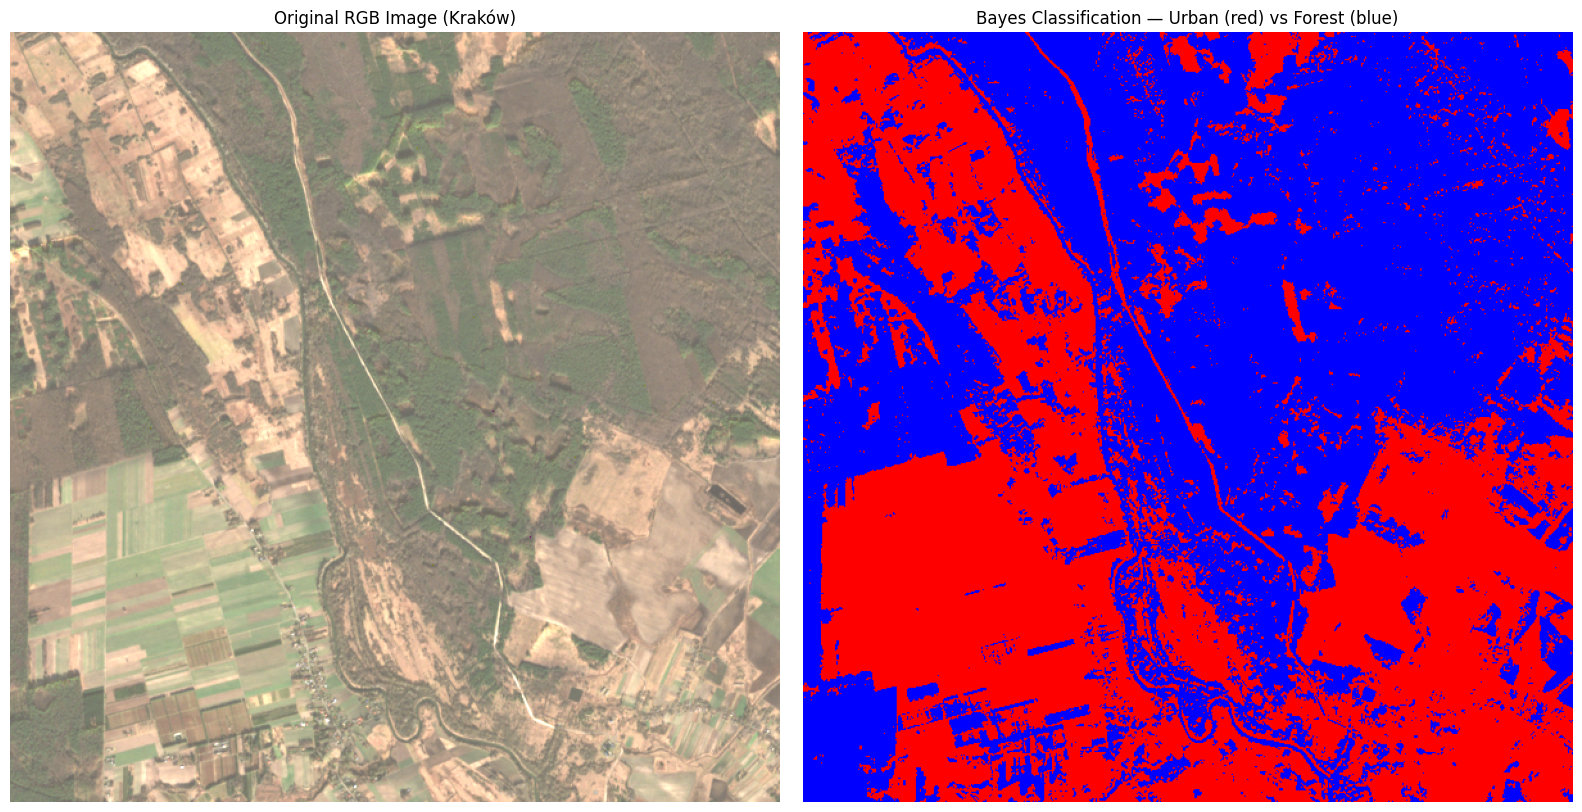

In [ ]:
# prep the image for classification
x_l, y_l = transformer.transform(lon_l, lat_l)
dx2 = 3000   
dy2 = 3000   
xmin_l, ymin_l, xmax_l, ymax_l = x_l - dx2, y_l - dy2, x_l + dx2, y_l + dy2
b4_crop_l2 = read_crop(band_paths_l["B04"], (xmin_l, ymin_l, xmax_l, ymax_l)).astype(np.float32) * scale  # R
b3_crop_l2 = read_crop(band_paths_l["B03"], (xmin_l, ymin_l, xmax_l, ymax_l)).astype(np.float32) * scale  # G
b2_crop_l2 = read_crop(band_paths_l["B02"], (xmin_l, ymin_l, xmax_l, ymax_l)).astype(np.float32) * scale  # B
cropped_rgb_l2 = np.dstack((b4_crop_l2, b3_crop_l2, b2_crop_l2)).astype(np.float32)
cropped_rgb_l2 /= np.percentile(cropped_rgb_l2, 99)
cropped_rgb_l2 = np.clip(cropped_rgb_l2, 0, 1)

def log_likelihood(rgb_img, params):
    eps = 1e-10
    ll = np.zeros(rgb_img.shape[:2], dtype=np.float32)
    for i, band in enumerate(["Red", "Green", "Blue"]):
        alpha, mu, sigma, m, s = params[band]
        band_vals = rgb_img[..., i]
        pdf = mixture_pdf(band_vals, alpha, mu, sigma, m, s)
        ll += np.log(np.maximum(pdf, eps))  # sum of log-likelihoods
    return ll

# compute
ll_forest = log_likelihood(cropped_rgb_l2, params_forest)
ll_urban  = log_likelihood(cropped_rgb_l2, params_urban)

# decision
pred_map = np.where(ll_urban > ll_forest, 0, 1)  # 0 = urban, 1 = forest


H, W = pred_map.shape
classified_rgb = np.zeros((H, W, 3), dtype=np.uint8)
classified_rgb[pred_map == 1] = [255, 0, 0]   # red = urban
classified_rgb[pred_map == 0] = [0, 0, 255]   # blue = forest

plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.imshow(np.clip(cropped_rgb_l2, 0, 1))
plt.title("Original RGB Image (Kraków)")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(classified_rgb)
plt.title("Bayes Classification — Urban (red) vs Forest (blue)")
plt.axis("off")

plt.tight_layout()
plt.show()

So, what's going on? Higher reflectance qualifies as forests, so the fields get lumped together with the urban areas. While it's weird, it does make sense looking at the reflectances.

## kNN

we'll try on the same image, expecting very similar results

Training samples: (2000, 3)
Running k-NN with k=1 ...
Running k-NN with k=3 ...
Running k-NN with k=5 ...


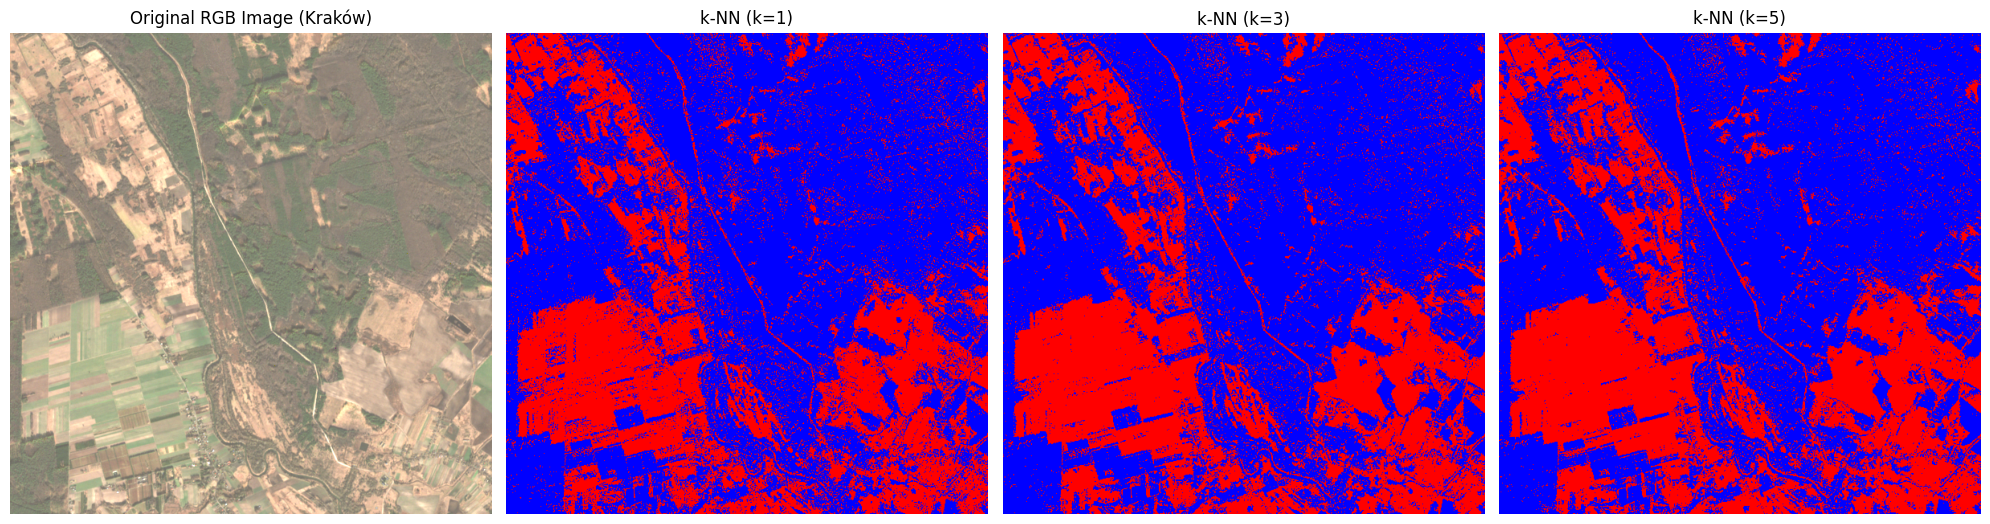

In [33]:
def to_training(rgb, label, n_samples):
    flat = rgb.reshape(-1, 3)
    n = min(n_samples, flat.shape[0])
    idx = np.random.default_rng(123).choice(flat.shape[0], size=n, replace=False)
    X = flat[idx]
    y = np.full(X.shape[0], label, dtype=np.uint8)
    return X, y

N_PER_CLASS = 1000
X_urban, y_urban = to_training(cropped_rgb_k, 0, N_PER_CLASS)   # 0 = urban (red)
X_forest, y_forest = to_training(cropped_rgb_l, 1, N_PER_CLASS)  # 1 = forest (blue)
X_train = np.vstack([X_urban, X_forest]).astype(np.float32)
y_train = np.concatenate([y_urban, y_forest])
print("Training samples:", X_train.shape)

# flatten test image
H, W, _ = cropped_rgb_l2.shape
X_test = cropped_rgb_l2.reshape(-1, 3).astype(np.float32)

def knn_predict(X_train, y_train, X_test, k=3, chunk=2048):
    n_test = X_test.shape[0]
    y_pred = np.empty(n_test, dtype=np.uint8)
    for start in range(0, n_test, chunk):
        end = min(start + chunk, n_test)
        T = X_test[start:end]
        diffs = T[:, None, :] - X_train[None, :, :]
        d2 = np.sum(diffs * diffs, axis=2)
        nn_idx = np.argpartition(d2, kth=k-1, axis=1)[:, :k]
        nn_labels = y_train[nn_idx]
        votes_forest = np.sum(nn_labels == 1, axis=1)
        y_pred[start:end] = (votes_forest > (k // 2)).astype(np.uint8)
    return y_pred

# run for k = 1, 3, 5
pred_maps = {}
for k in (1, 3, 5):
    print(f"Running k-NN with k={k} ...")
    preds = knn_predict(X_train, y_train, X_test, k=k, chunk=1024)
    pred_maps[k] = preds.reshape(H, W)


fig, axes = plt.subplots(1, 4, figsize=(20, 8))
axes[0].imshow(np.clip(cropped_rgb_l2, 0, 1))
axes[0].set_title("Original RGB Image (Kraków)")
axes[0].axis("off")

for i, k in enumerate([1, 3, 5], start=1):
    pred_map = pred_maps[k]
    classified_rgb = np.zeros((H, W, 3), dtype=np.uint8)
    classified_rgb[pred_map == 1] = [255, 0, 0] 
    classified_rgb[pred_map == 0] = [0, 0, 255] 

    axes[i].imshow(classified_rgb)
    axes[i].set_title(f"k-NN (k={k})")
    axes[i].axis("off")

plt.tight_layout()
plt.show()



Mostly the difference can be seen in planes/fields, where higher K produces more uniform predictions. I'd consider this somewhat worse than Bayes in this case. Also oddly I had to swap the colors around, I'm assuming i messed up somewhere and its not the predictor perfectly flipping the results. I had a lot of help writing this code and at some point I forgot the finer details, so I will need to come back to it and figure out what went wrong.